Daily Data Stream from 3 different subreddits : r/Spotify , r/popheads, r/music

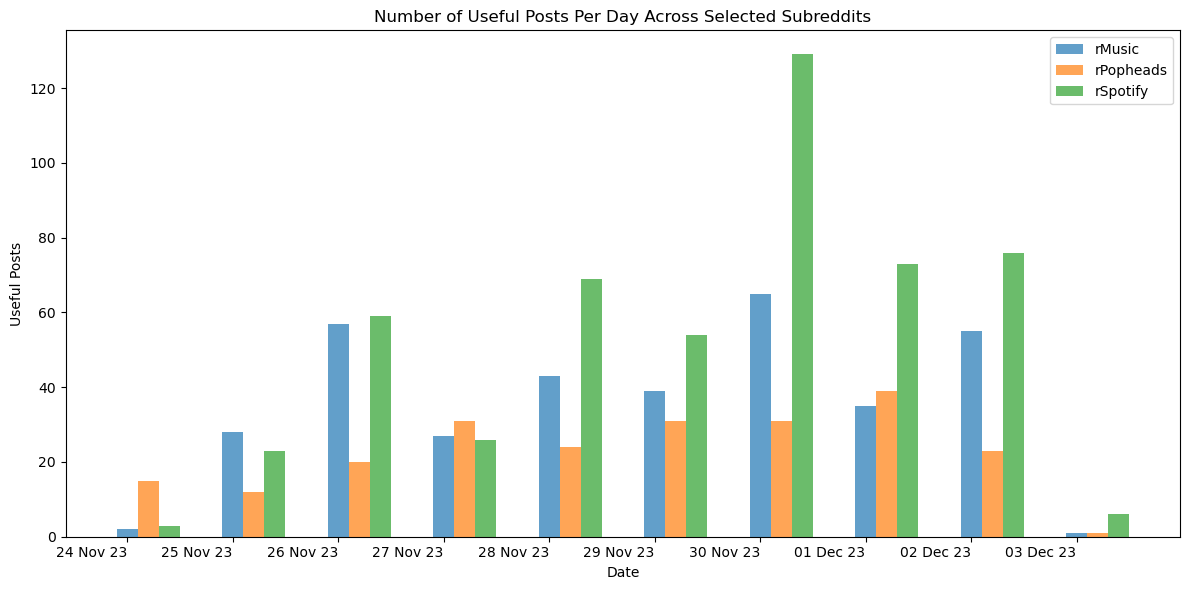

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from pymongo import MongoClient

client = MongoClient('mongodb://127.0.0.1:27017/')
db = client.chestnut
collections = ['rMusic', 'rSpotify', 'rPopheads']

all_data = pd.DataFrame()

for collection_name in collections:
    collection = db[collection_name]
    cursor = collection.find({}, {"_id": 0, "created_date": 1, "post": 1})

    data = [{"collection": collection_name, "created_date": post.get("created_date"), "post": post.get("post")} for post in cursor]
    collection_df = pd.DataFrame(data)
    all_data = pd.concat([all_data, collection_df], ignore_index=True)

all_data['created_date'] = pd.to_datetime(all_data['created_date'])

all_data['date'] = all_data['created_date'].dt.strftime('%d %b %y')  

dates_to_exclude = ['16 Nov 23', '30 Jul 22', '02 Nov 23']
all_data_filtered = all_data[~all_data['date'].isin(dates_to_exclude)]

all_data_filtered = all_data_filtered.copy()
all_data_filtered['date'] = pd.to_datetime(all_data_filtered['date'], format='%d %b %y')

all_data_filtered = all_data_filtered.sort_values(by='date')

daily_post_counts = all_data_filtered.groupby(['collection', 'date']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 6))

bar_width = 0.2 
bar_positions = range(len(daily_post_counts.columns))

for i, subreddit in enumerate(daily_post_counts.index):
    plt.bar(
        [pos + i * bar_width for pos in bar_positions],
        daily_post_counts.loc[subreddit],
        width=bar_width,
        label=subreddit,
        alpha=0.7
    )

plt.title('Number of Useful Posts Per Day Across Selected Subreddits')
plt.xlabel('Date')
plt.ylabel('Useful Posts')
plt.legend()
plt.xticks(bar_positions, daily_post_counts.columns.strftime('%d %b %y'), ha='right')
plt.grid(False) 

plt.tight_layout()
plt.show()


Research Ques 1: Is there a correlation between the level of activity on artist-specific subreddits (e.g., official subreddits) and the artist's success on Spotify, measured by metrics such as number of top hits and overall popularity?

The approach here I went through is by collecting the popularity of the artist whose songs are on the top daily hits charts: we get from spotify GET artist_details api and and plot the below graph. Now here, we have x-axis represents the artists who are trending in the top daily list playlist (in order) and y-axis represents the popularity on spotify - between 0 and 100; 100 being the most popular, it depends on the popularity of the artists tracks.

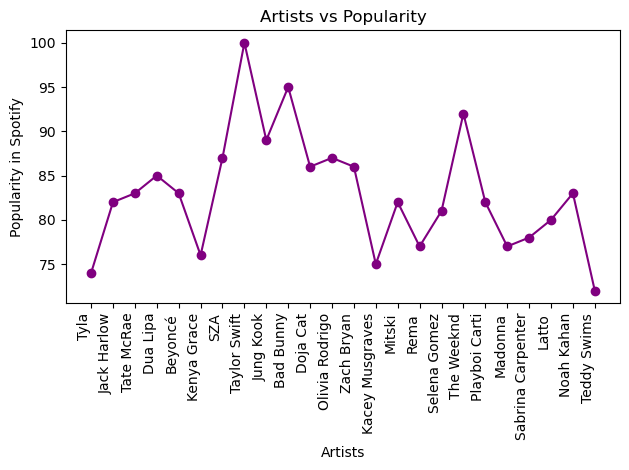

In [3]:
import matplotlib.pyplot as plt
import json
import pymongo

comments_by_artist = {}
conn = pymongo.MongoClient('mongodb://127.0.0.1:27017/')
db = conn.chestnut
collection = db.artists_details

artists_data = list(collection.find({}))

artist_names = [artist["name"] for artist in artists_data]
popularity_scores = [artist["popularity"] for artist in artists_data]

plt.plot(artist_names, popularity_scores, marker='o', linestyle='-', color='purple')
plt.xlabel('Artists')
plt.ylabel('Popularity in Spotify')
plt.title('Artists vs Popularity')
plt.xticks(rotation=90, ha='right')
plt.grid(False)  
plt.tight_layout()
plt.show()

Further, I have collected the posts from earch artists official subreddits and have plotted a graph for fan engagagements in their subreddit and how does it change over the time and why does it change 

MOST COMMON REASONS
- a new song from the album
- tour fan threads
- social and public appearences (paparazzi) 
and many more....

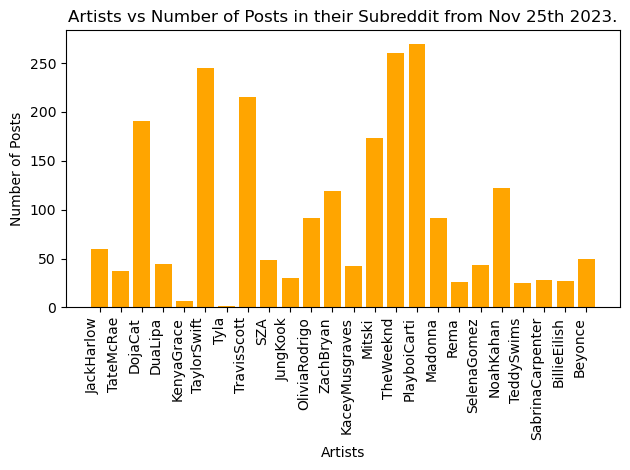

In [4]:
from collections import defaultdict
import matplotlib.pyplot as plt
import json
import pymongo

comments_by_artist = {}
conn = pymongo.MongoClient('mongodb://127.0.0.1:27017/')
db = conn.chestnut
collection = db.artists_posts

artists_posts_data = list(collection.find({}))

artist_post_counts = defaultdict(int)
for post in artists_posts_data:
    artist_name = post["artist"]
    artist_post_counts[artist_name] += 1

artists = list(artist_post_counts.keys())
post_counts = list(artist_post_counts.values())

plt.bar(artists, post_counts, color='orange')
plt.xlabel('Artists')
plt.ylabel('Number of Posts')
plt.title('Artists vs Number of Posts in their Subreddit from Nov 25th 2023.')
plt.xticks(rotation=90, ha='right')
plt.grid(False)  
plt.tight_layout()
plt.show()

Now here, we will be looking out whether there is a correlation in the number of posts in their subreddits which makes an impact on their populartiy on Spotify by plotting a dual-axis bar and line chart which will be most convinient for us to study and understand.

Moving on, we are calculating the pearson coefficient coefficient between popularity scores and the number of posts.

Artists like "Taylor Swift," "Travis Scott," and "The Weeknd" have high popularity scores, indicating a strong presence or following.
"playboicarti" has both a high popularity score and the highest number of posts, suggesting a combination of popularity and active discussion.
"Kenya Grace" has a low number of posts, indicating a comparatively lower level of discussion or content related to this artist despite having a popularity score of 76.

If the coefficient is positive, it suggests a positive correlation (as the number of posts increases, popularity tends to increase).

Correlation Coefficient: 0.6177842496397459
P-value: 0.0028423379788839864


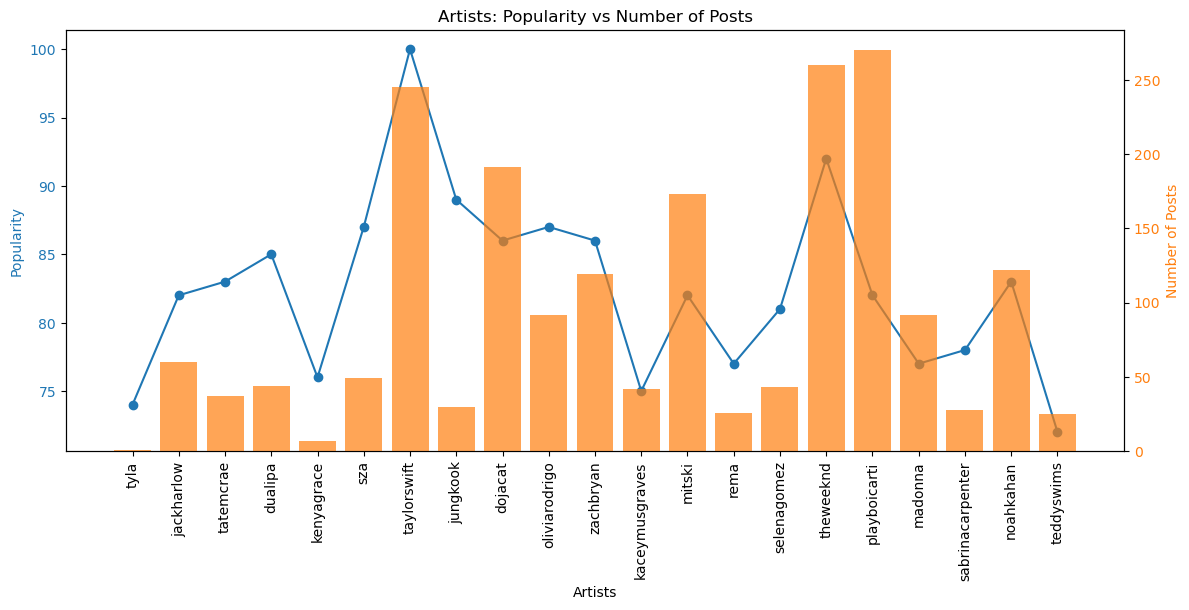

In [5]:
import matplotlib.pyplot as plt
import json
import pymongo
from collections import defaultdict
from scipy.stats import pearsonr

conn = pymongo.MongoClient('mongodb://127.0.0.1:27017/')
db = conn.chestnut

artists_details_collection = db.artists_details
artists_posts_collection = db.artists_posts

artists_details_data = list(artists_details_collection.find({}))
artist_names = [artist["name"].lower().replace(" ", "") for artist in artists_details_data]

collection = db.artists_posts
artists_posts_data = list(collection.find({}))

artist_post_counts = defaultdict(int)
for post in artists_posts_data:
    artist_name = post["artist"].lower().replace(" ", "")
    artist_post_counts[artist_name] += 1

unique_artists_details = set(artist_names)
unique_artists_posts = set(artist_post_counts.keys())

common_artists = list(unique_artists_details.intersection(unique_artists_posts))
common_artists.sort(key=lambda x: artist_names.index(x))

popularity_scores = [artist["popularity"] for artist in artists_details_data if artist["name"].lower().replace(" ", "") in common_artists]
post_counts = [artist_post_counts[artist] for artist in common_artists]

#print("Unique Popularity Scores:", set(popularity_scores))
#print("Unique Post Counts:", set(post_counts))

fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel('Artists')
ax1.set_ylabel('Popularity', color=color)
ax1.plot(common_artists, popularity_scores, marker='o', linestyle='-', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.tick_params(axis='x', rotation=90)
ax1.grid(False)

ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Number of Posts', color=color)
ax2.bar(common_artists, post_counts, color=color, alpha=0.7)
ax2.tick_params(axis='y', labelcolor=color)
ax2.grid(False)

fig.tight_layout()

# Correlation analysis starts here
if len(popularity_scores) > 1 and len(post_counts) > 1:
    correlation_coefficient, p_value = pearsonr(popularity_scores, post_counts)
    print(f"Correlation Coefficient: {correlation_coefficient}")
    print(f"P-value: {p_value}")
else:
    print("Correlation coefficient is not defined due to constant input array(s).") 

plt.title('Artists: Popularity vs Number of Posts')
plt.xticks(rotation='vertical', ha='right')
plt.show()


Lets plot, analyze and visualizes sentiment scores along with popularity and post counts for a set of artists.

In the below graph some of the artists have a neutral sentiment score even with their song bein released and being on top of the charts for weeks and some have maintained the score with respect to their popularity (fan following, ongoing tour, album drop etc)

Artists such as Taylor Swift has been breaking records with her ongoing ERAs and her high profile relationship news with Travis Kelce which leads to the content of posts related to her being more positive which has maintained her popularity.

Even though Playboy Carti have a highest number of posts (colab with popular artists such as TheWeeknd and Madonna for a song), the sentiment score is 0, which suggests that they have neutral sentiments in their posts. The sentiments in their posts is neither strongly positve or negative.
Tyla too has neutral sentiments due to collab with Travis Scott

Jack Harlow, ranking in top charts for 4 consecutive days with new songhas a diverse sentiments - postive but not high (mix of negative as well).


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/dshetty3/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


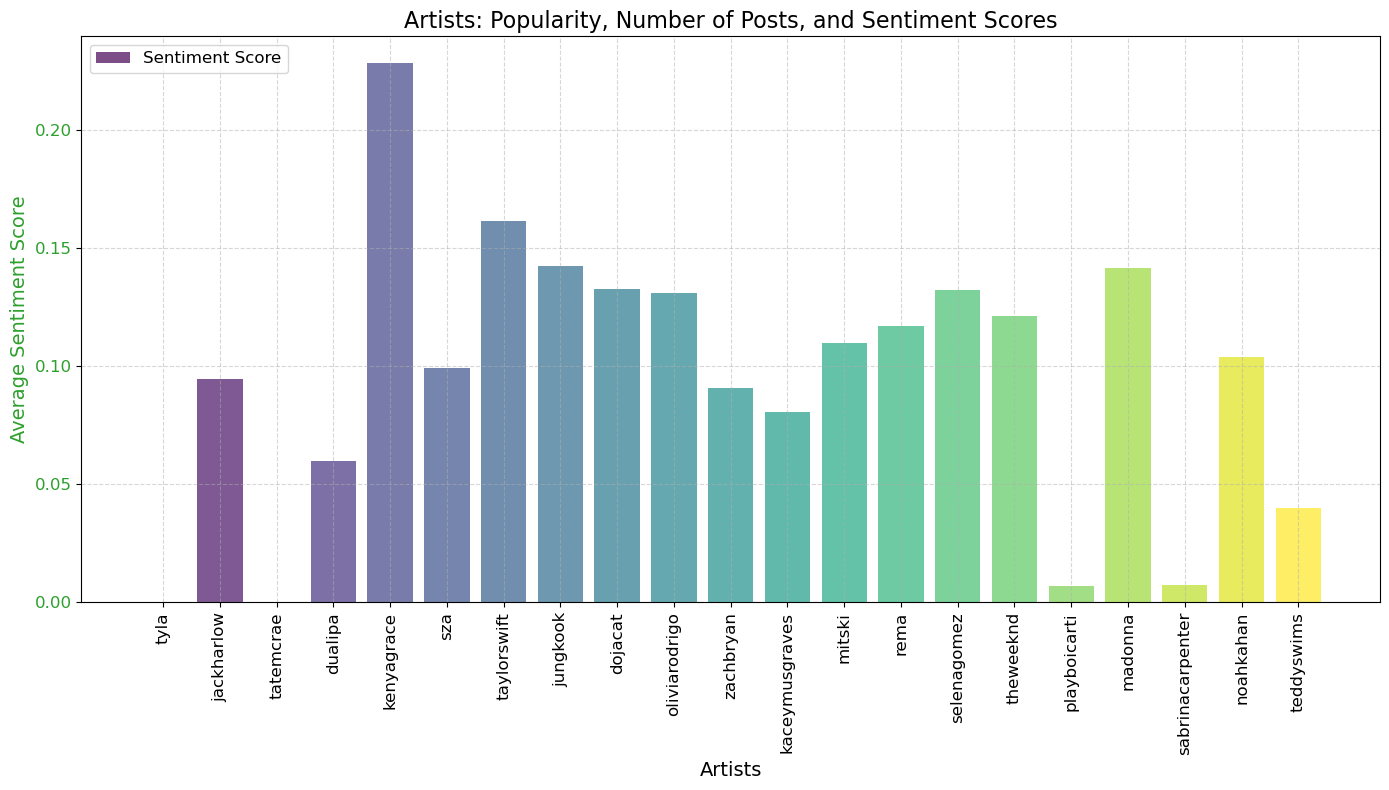

In [6]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import pymongo
from collections import defaultdict
import matplotlib.pyplot as plt
import json
from scipy.stats import pearsonr
import numpy as np

conn = pymongo.MongoClient('mongodb://127.0.0.1:27017/', serverSelectionTimeoutMS=60000)
db = conn.chestnut

artists_details_collection = db.artists_details
artists_posts_collection = db.artists_posts

artists_details_data = list(artists_details_collection.find({}))
artist_names = [artist["name"].lower().replace(" ", "") for artist in artists_details_data]  

collection = db.artists_posts
artists_posts_data = list(collection.find({}))

artist_post_counts = defaultdict(int)
for post in artists_posts_data:
    artist_name = post["artist"].lower().replace(" ", "") 
    artist_post_counts[artist_name] += 1

unique_artists_details = set(artist_names)  
unique_artists_posts = set(artist_post_counts.keys())

common_artists = list(unique_artists_details.intersection(unique_artists_posts))

common_artists.sort(key=lambda x: artist_names.index(x))

popularity_scores = [artist["popularity"] for artist in artists_details_data if artist["name"].lower().replace(" ", "") in common_artists]
post_counts = [artist_post_counts[artist] for artist in common_artists]

nltk.download('vader_lexicon') 
sia = SentimentIntensityAnalyzer()

post_sentiments = defaultdict(list)
for post in artists_posts_data:
    artist_name = post["artist"].lower().replace(" ", "")
    text = post["post"]
    sentiment_score = sia.polarity_scores(text)["compound"]
    post_sentiments[artist_name].append(sentiment_score)

average_sentiments = {artist: sum(scores) / len(scores) for artist, scores in post_sentiments.items()}

fig, ax3 = plt.subplots(figsize=(14, 8))

colors = plt.cm.viridis(np.linspace(0, 1, len(common_artists)))

ax3.set_xlabel('Artists', fontsize=14)
ax3.set_ylabel('Average Sentiment Score', color='tab:green', fontsize=14)
ax3.bar(common_artists, [average_sentiments[artist] for artist in common_artists], color=colors, alpha=0.7)

ax3.tick_params(axis='y', labelcolor='tab:green', labelsize=12)
ax3.tick_params(axis='x', rotation=90, labelsize=12)
ax3.grid(True, linestyle='--', alpha=0.5)

plt.title('Artists: Popularity, Number of Posts, and Sentiment Scores', fontsize=16)

plt.legend(['Sentiment Score'], loc='upper left', fontsize=12)

plt.tight_layout() 
plt.show()


                                        --------- RESEARCH QUESTION 1 DONE --------